# Going Deeper - CV
## ResNet-50 Augmentation
---
평가문항|상세기준
------|------
CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

### 프로젝트: CutMix 또는 Mixup 비교실험 하기
CutMix 또는 Mixup을 적용해 모델을 훈련시켜 보자.   
데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시키자.   
결과를 수치화하고 비교해보자.

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 0. 데이터 불러오기

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

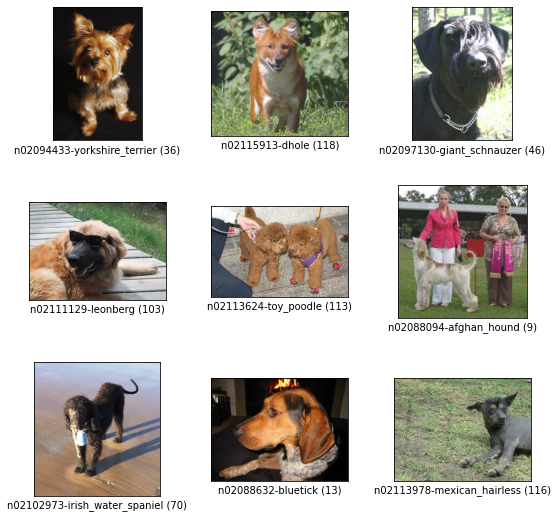

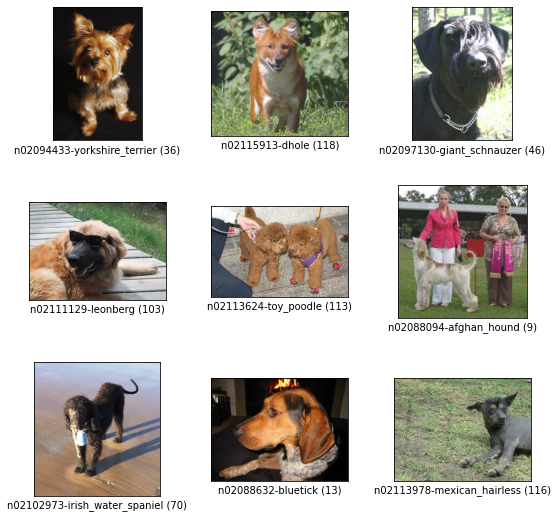

In [5]:
tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기
* 데이터셋에 CutMix 또는 Mixup augmentation을 적용해보자.
---
### Cutmix Augmentation 적용
**CutMix : Regularization Strategy to Train Strong Classifiers with Localizable Features**   
 모델이 객체의 차이를 식별할 수 있는 부분에 집중하지 않고, 덜 구별되는 부분 및 이미지의 전체적인 구역을 보고 학습하도록 하여 일반화와 localization 성능을 높이는 방법이다. 또한 train set과 test set의 분포가 다른 경우를 의미하는 OOD(Out Of Distribution)와 이미지가 가려진 sample, adversarial sample에서의 robustness도 좋은 성능을 나타낸다.     
 CutMix는 이미지의 부분 영역을 다른 이미지의 부분영역으로 대체한다.

#### 1) 이미지 섞기

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [7]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

#### 2) 라벨 섞기

In [8]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MIxup Augmentation 적용
Mixup은 CutMix보다 간단하게 이미지와 라벨을 섞어준다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다.   
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [11]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

In [12]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2. 모델 만들기
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

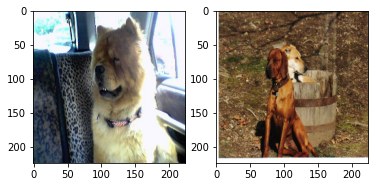

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [14]:
# ResNet50 중 imagenet으로 훈련된 모델 불러오기.
# include_top은 마지막 fully connected layer를 포함할지 여부.
# 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor)부분만 불러와 
# 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다.
# 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 
# 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문이다.
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 3. 모델 훈련하기
주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [15]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [19]:
# 이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 
# 적용되지 않은 데이터셋을 학습시키고, 검증을 진행한다.
EPOCH = 10

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 182s 228ms/step - loss: 2.1945 - accuracy: 0.4488 - val_loss: 3.5463 - val_accuracy: 0.1634
Epoch 2/10
750/750 [==============================] - 170s 227ms/step - loss: 0.6883 - accuracy: 0.8115 - val_loss: 1.0595 - val_accuracy: 0.6898
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 0.2101 - accuracy: 0.9601 - val_loss: 0.9624 - val_accuracy: 0.7203
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0627 - accuracy: 0.9945 - val_loss: 0.9197 - val_accuracy: 0.7339
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0282 - accuracy: 0.9989 - val_loss: 0.9118 - val_accuracy: 0.7374
Epoch 6/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0187 - accuracy: 0.9992 - val_loss: 0.9492 - val_accuracy: 0.7339
Epoch 7/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0136 - accuracy: 0.9997 - val_loss: 0.9583 -

In [20]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 178s 227ms/step - loss: 2.2376 - accuracy: 0.4338 - val_loss: 2.9516 - val_accuracy: 0.2725
Epoch 2/10
750/750 [==============================] - 154s 205ms/step - loss: 0.9416 - accuracy: 0.7319 - val_loss: 1.2622 - val_accuracy: 0.6400
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 0.4845 - accuracy: 0.8657 - val_loss: 1.2997 - val_accuracy: 0.6424
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 0.2524 - accuracy: 0.9412 - val_loss: 1.0593 - val_accuracy: 0.7034
Epoch 5/10
750/750 [==============================] - 154s 205ms/step - loss: 0.1408 - accuracy: 0.9728 - val_loss: 0.9993 - val_accuracy: 0.7218
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0820 - accuracy: 0.9876 - val_loss: 1.0282 - val_accuracy: 0.7204
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0498 - accuracy: 0.9935 - val_loss: 0.9749 -

In [23]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 159s 206ms/step - loss: 2.3511 - accuracy: 0.6459 - val_loss: 1.3102 - val_accuracy: 0.6549
Epoch 2/10
750/750 [==============================] - 154s 205ms/step - loss: 2.2365 - accuracy: 0.6870 - val_loss: 1.3455 - val_accuracy: 0.6470
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 2.1572 - accuracy: 0.6917 - val_loss: 1.2644 - val_accuracy: 0.6701
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 2.0806 - accuracy: 0.7123 - val_loss: 1.4527 - val_accuracy: 0.6398
Epoch 5/10
750/750 [==============================] - 154s 205ms/step - loss: 2.0398 - accuracy: 0.7295 - val_loss: 1.2386 - val_accuracy: 0.6790
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 1.9927 - accuracy: 0.7337 - val_loss: 1.3120 - val_accuracy: 0.6629
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 1.9471 - accuracy: 0.7417 - val_loss: 1.2487 -

In [24]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 159s 206ms/step - loss: 1.9606 - accuracy: 0.8062 - val_loss: 1.5004 - val_accuracy: 0.6298
Epoch 2/10
750/750 [==============================] - 154s 205ms/step - loss: 1.9131 - accuracy: 0.8215 - val_loss: 1.4478 - val_accuracy: 0.6474
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 1.9142 - accuracy: 0.8193 - val_loss: 1.2848 - val_accuracy: 0.6867
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 1.8720 - accuracy: 0.8319 - val_loss: 1.3767 - val_accuracy: 0.6592
Epoch 5/10
750/750 [==============================] - 154s 205ms/step - loss: 1.8505 - accuracy: 0.8386 - val_loss: 1.3644 - val_accuracy: 0.6667
Epoch 6/10
750/750 [==============================] - 154s 205ms/step - loss: 1.8210 - accuracy: 0.8391 - val_loss: 1.2933 - val_accuracy: 0.6837
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 1.8328 - accuracy: 0.8382 - val_loss: 1.3778 -

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

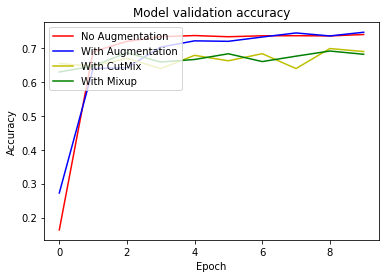

In [26]:
# 훈련 과정 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.show()

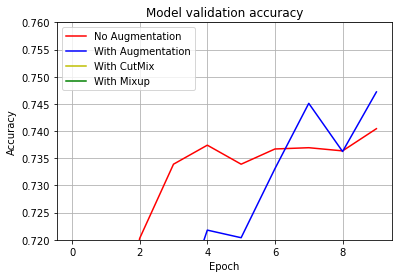

In [27]:
# 좀 더 확대해 살펴보자.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류  정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.